# QUORA QQP

### TF-IDF

#### Performance Metrics


- Log Loss 
- Binary Confusion Matrix


- SGDClassifier
- XGBoost

In [3]:
# importing the libraries

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle

from datetime import datetime

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, log_loss

from scipy.sparse import hstack
from xgboost import XGBClassifier

In [4]:
# importing the preprocessed dataset

df = pd.read_pickle("./questions_preprocessed.pkl")

In [5]:
df.head(10)

,question1,question2,is_duplicate,q1_len,q2_len,q1_word_len,q2_word_len,q1_char_len,q2_char_len,len_diff,word_len_diff,char_len_diff,common_words,common_words_ratio,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
0,step step guide invest share market india,step step guide invest share market,0,66,57,14,12,53,46,9,2,7,10,0.384615,92,100,92,100
1,story kohinoor kohinoor diamond,would happen indian government stole kohinoor ...,0,51,88,8,13,44,76,37,5,32,4,0.190476,59,94,59,84
2,increase speed internet connection using vpn,internet speed increased hacking dns,0,73,59,14,10,60,50,14,4,10,4,0.166667,55,56,70,70
3,mentally lonely solve,find remainder math2324math divided 2423,0,50,65,11,9,40,57,15,2,17,0,0.000000,23,29,23,23
4,one dissolve water quikly sugar salt methane c...,fish would survive salt water,0,76,39,13,7,64,33,37,6,31,2,0.100000,43,52,40,51
5,astrology capricorn sun cap moon cap risingwha...,im triple capricorn sun moon ascendant caprico...,1,86,90,16,16,71,75,4,0,4,8,0.250000,64,65,60,69
6,buy tiago,keeps childern active far phone video games,0,19,62,4,11,16,52,43,7,36,0,0.000000,19,33,19,19
7,good geologist,great geologist,1,30,41,7,9,24,33,11,2,9,4,0.250000,76,71,76,78
8,use shi instead shi,use instead,0,31,37,8,8,24,30,6,0,6,6,0.375000,73,82,73,100
9,motorola company hack charter motorolla dcx3400,hack motorola dcx3400 free internet,0,60,49,9,9,52,41,11,0,11,3,0.166667,51,60,59,75


In [39]:
# creating a single list of unique questions

uniq_questions = pd.concat((df['question1'], df['question2'])).unique()   

### TF-IDF Word Level

In [81]:
# applying tfidf vectorizer

tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}')
tfidf_vect.fit(uniq_questions)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='\\w{1,}', tokenizer=None,
                use_idf=True, vocabulary=None)

In [82]:
# transform question1 and question2 using tfidf vectorizer

question1_vect = tfidf_vect.transform(df['question1'])
question2_vect = tfidf_vect.transform(df['question2'])

In [9]:
# list all column names

print(df.columns)

Index(['question1', 'question2', 'is_duplicate', 'q1_len', 'q2_len',
       'q1_word_len', 'q2_word_len', 'q1_char_len', 'q2_char_len', 'len_diff',
       'word_len_diff', 'char_len_diff', 'common_words', 'common_words_ratio',
       'fuzz_ratio', 'fuzz_partial_ratio', 'token_sort_ratio',
       'token_set_ratio'],
      dtype='object')


The following features are available for building the model:

- question1
- question2
- q1_len
- q2_len
- q1_word_len
- q1_word_len
- q1_char_len
- q1_char_len
- len_diff
- word_len_diff
- char_len_diff
- common_words
- common_words_ratio
- fuzz_ratio
- fuzz_partial_ratio
- token_sort_ratio
- token_set_ratio

In [83]:
# all features
X = hstack((question1_vect, question2_vect, df[['q1_len','q2_len','q1_word_len','q1_word_len','q1_char_len','q1_char_len','len_diff','word_len_diff','char_len_diff','common_words','common_words_ratio', 'fuzz_ratio', 'fuzz_partial_ratio', 'token_sort_ratio', 'token_set_ratio']]))

# output feature: is_duplicate
y = df['is_duplicate']

In [84]:
# splitting the training and testing dataset

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [74]:
# plotting the confusion matrix

def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".0f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")

### SGDClassifier

In [13]:
start = datetime.utcnow()
alpha = [10 ** x for x in range(-5, 2)]

log_loss_array = []
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', n_jobs=-1, random_state=42)
    clf.fit(X_train, y_train)
    y_pred_prob = clf.predict_proba(X_test)
    log_loss_array.append(log_loss(y_test, y_pred_prob, labels=clf.classes_))
    print("For alpha={}, log loss is {}".format(i, log_loss_array[-1]))

print("Total running time: {}".format(datetime.utcnow() - start))

For alpha=1e-05, log loss is 2.434760298831177
For alpha=0.0001, log loss is 0.9475600036825564
For alpha=0.001, log loss is 0.5074072864166543
For alpha=0.01, log loss is 0.6358597770442553
For alpha=0.1, log loss is 0.5622769130756479
For alpha=1, log loss is 0.5706200226921889
For alpha=10, log loss is 0.5875559233174091
Total running time: 0:02:13.633767


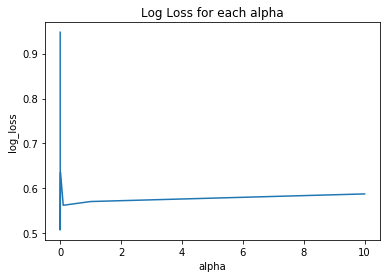

In [17]:
data_plot = pd.DataFrame(
    {"alpha": alpha[1:], "log_loss": log_loss_array[1:]})
sns.lineplot(x="alpha", y="log_loss", data=data_plot)
plt.title('Log Loss for each alpha')
plt.show()

We are selecting alpha value as 0.001 as it provided the minimum log loss of 0.471.

In [76]:
clf = SGDClassifier(alpha=0.001, penalty='l2', loss='log', n_jobs=-1, random_state=42)
clf.fit(X_train, y_train)
y_pred_prob = clf.predict_proba(X_test)
y_pred = clf.predict(X_test)

Log Loss (Training): 0.5100124399601744

Log Loss (Testing): 0.5074072864166543

Accuracy Score: 0.7170025967602325

Classification Report:

              precision    recall  f1-score   support

           0       0.80      0.74      0.77     51240
           1       0.60      0.67      0.64     29630

    accuracy                           0.72     80870
   macro avg       0.70      0.71      0.70     80870
weighted avg       0.73      0.72      0.72     80870


Confustion Matrix: 



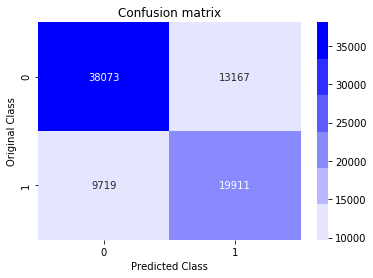

In [77]:
print("Log Loss (Training): {}\n".format(log_loss(y_train, clf.predict_proba(X_train))))
print("Log Loss (Testing): {}\n".format(log_loss(y_test, y_pred_prob, labels=clf.classes_)))
print("Accuracy Score: {}\n".format(accuracy_score(y_test, y_pred)))
print('Classification Report:\n')
print(classification_report(y_test, y_pred))
print('\nConfustion Matrix: \n')
plot_confusion_matrix(y_test, y_pred)

### XGBClassifier 


In [86]:
xgb_clf = XGBClassifier(objective='binary:logistic', eval_metric='logloss', n_jobs=-1, random_state=42)
xgb_clf.fit(X_train, y_train)
y_pred_prob = xgb_clf.predict_proba(X_test)
y_pred = xgb_clf.predict(X_test)

Log Loss (Training): 0.39101376031273194

Log Loss (Testing): 0.4003839339062982

Accuracy Score: 0.799814517126252

Classification Report:

              precision    recall  f1-score   support

           0       0.84      0.84      0.84     51240
           1       0.73      0.72      0.73     29630

    accuracy                           0.80     80870
   macro avg       0.78      0.78      0.78     80870
weighted avg       0.80      0.80      0.80     80870


Confustion Matrix: 



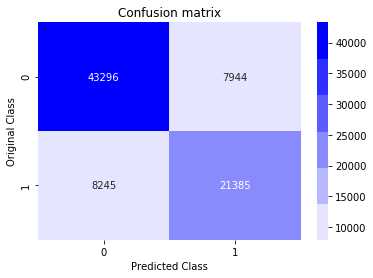

In [87]:
print("Log Loss (Training): {}\n".format(log_loss(y_train, xgb_clf.predict_proba(X_train))))
print("Log Loss (Testing): {}\n".format(log_loss(y_test, y_pred_prob, labels=clf.classes_)))
print("Accuracy Score: {}\n".format(accuracy_score(y_test, y_pred)))
print('Classification Report:\n')
print(classification_report(y_test, y_pred))
print('\nConfustion Matrix: \n')
plot_confusion_matrix(y_test, y_pred)

### TF-IDF N-gram Level

In [88]:
# applying tfidf vectorizer

tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3))
tfidf_vect.fit(uniq_questions)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(2, 3), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='\\w{1,}', tokenizer=None,
                use_idf=True, vocabulary=None)

In [89]:
# transform question1 and question2 using tfidf vectorizer

question1_vect = tfidf_vect.transform(df['question1'])
question2_vect = tfidf_vect.transform(df['question2'])

In [90]:
# all features
X = hstack((question1_vect, question2_vect, df[['q1_len','q2_len','q1_word_len','q1_word_len','q1_char_len','q1_char_len','len_diff','word_len_diff','char_len_diff','common_words','common_words_ratio', 'fuzz_ratio', 'fuzz_partial_ratio', 'token_sort_ratio', 'token_set_ratio']]))

# output feature: is_duplicate
y = df['is_duplicate']

In [91]:
# splitting the training and testing dataset

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
# SGDClassifier
start = datetime.utcnow()
alpha = [10 ** x for x in range(-5, 2)]

log_loss_array = []
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', n_jobs=-1, random_state=42)
    clf.fit(X_train, y_train)
    y_pred_prob = clf.predict_proba(X_test)
    log_loss_array.append(log_loss(y_test, y_pred_prob, labels=clf.classes_))
    print("For alpha={}, log loss is {}".format(i, log_loss_array[-1]))

print("Total running time: {}".format(datetime.utcnow() - start))

For alpha=1e-05, log loss is 1.1339147747494753
For alpha=0.0001, log loss is 0.5315276574159216
For alpha=0.001, log loss is 0.5401991125627892
For alpha=0.01, log loss is 0.6479296345469859
For alpha=0.1, log loss is 0.5631060933418307
For alpha=1, log loss is 0.5707011366128483
For alpha=10, log loss is 0.5875638803535617
Total running time: 0:03:46.250021


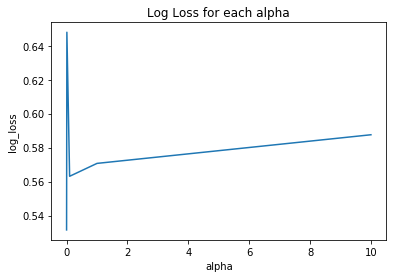

In [31]:
data_plot = pd.DataFrame(
    {"alpha": alpha[1:], "log_loss": log_loss_array[1:]})
sns.lineplot(x="alpha", y="log_loss", data=data_plot)
plt.title('Log Loss for each alpha')
plt.show()

In [92]:
clf = SGDClassifier(alpha=0.0001, penalty='l2', loss='log', n_jobs=-1, random_state=42)
clf.fit(X_train, y_train)
y_pred_prob = clf.predict_proba(X_test)
y_pred = clf.predict(X_test)

Log Loss (Training): 0.5268833562460734

Log Loss (Testing): 0.5315276574159216

Accuracy Score: 0.7204154816371955

Classification Report:

              precision    recall  f1-score   support

           0       0.81      0.73      0.77     51240
           1       0.60      0.71      0.65     29630

    accuracy                           0.72     80870
   macro avg       0.71      0.72      0.71     80870
weighted avg       0.73      0.72      0.72     80870


Confustion Matrix: 



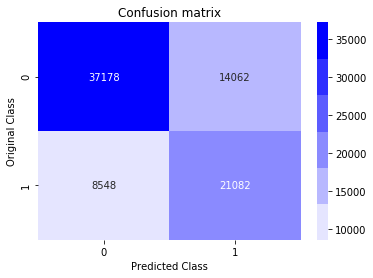

In [93]:
print("Log Loss (Training): {}\n".format(log_loss(y_train, clf.predict_proba(X_train))))
print("Log Loss (Testing): {}\n".format(log_loss(y_test, y_pred_prob, labels=clf.classes_)))
print("Accuracy Score: {}\n".format(accuracy_score(y_test, y_pred)))
print('Classification Report:\n')
print(classification_report(y_test, y_pred))
print('\nConfustion Matrix: \n')
plot_confusion_matrix(y_test, y_pred)

In [94]:
# XGBClassifier
xgb_clf = XGBClassifier(objective='binary:logistic', eval_metric='logloss', n_jobs=-1, random_state=42)
xgb_clf.fit(X_train, y_train)
y_pred_prob = xgb_clf.predict_proba(X_test)
y_pred = xgb_clf.predict(X_test)

Log Loss (Training): 0.4207070597259291

Log Loss (Testing): 0.42440915390133266

Accuracy Score: 0.7725238036354644

Classification Report:

              precision    recall  f1-score   support

           0       0.83      0.80      0.82     51240
           1       0.68      0.73      0.70     29630

    accuracy                           0.77     80870
   macro avg       0.76      0.76      0.76     80870
weighted avg       0.78      0.77      0.77     80870


Confustion Matrix: 



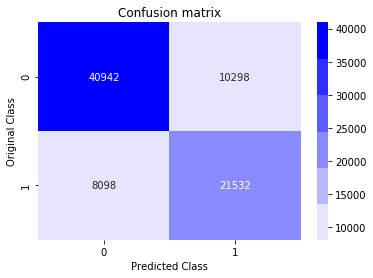

In [95]:
print("Log Loss (Training): {}\n".format(log_loss(y_train, xgb_clf.predict_proba(X_train))))
print("Log Loss (Testing): {}\n".format(log_loss(y_test, y_pred_prob, labels=clf.classes_)))
print("Accuracy Score: {}\n".format(accuracy_score(y_test, y_pred)))
print('Classification Report:\n')
print(classification_report(y_test, y_pred))
print('\nConfustion Matrix: \n')
plot_confusion_matrix(y_test, y_pred)

#### TF-IDF Word Level XGBoost

In [57]:
params = {}
params['max_depth'] = [2, 4, 6, 8]
params['min_child_weight'] = [1, 2, 3]
params['eta'] = [0.01, 0.03, 0.1, 0.3]
params

{'max_depth': [2, 4, 6, 8],
 'min_child_weight': [1, 2, 3],
 'eta': [0.01, 0.03, 0.1, 0.3]}

In [66]:
xgb_clf = XGBClassifier(objective='binary:logistic', eval_metric='logloss', n_jobs=-1, random_state=42, verbose=1)

In [67]:
grid_clf = GridSearchCV(xgb_clf, param_grid=params, n_jobs=-1, verbose=1, cv=3)

In [68]:
start = datetime.utcnow()
grid_clf.fit(X_train, y_train)
print('Total running time: {}'.format(datetime.utcnow() - start))

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 18.3min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 34.1min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 40.2min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 51.4min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 70.1min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed: 88.3min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 100.4min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed: 123.5min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 139.3min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed: 159.1min
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed: 169.3min finished


Total running time: 2:53:38.840761


In [69]:
grid_clf.best_estimator_

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.3,
              eval_metric='logloss', gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints=None, learning_rate=0.300000012,
              max_delta_step=0, max_depth=8, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=-1,
              num_parallel_tree=1, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method=None, validate_parameters=False, verbose=10,
              verbosity=None)

In [70]:
y_pred_prob = grid_clf.best_estimator_.predict_proba(X_test)
y_pred = grid_clf.best_estimator_.predict(X_test)

Log Loss (Training): 0.3695228640596467

Log Loss (Testing): 0.3893566904191875

Accuracy Score: 0.8071596389266724

Classification Report:

              precision    recall  f1-score   support

           0       0.84      0.85      0.85     51240
           1       0.74      0.73      0.73     29630

    accuracy                           0.81     80870
   macro avg       0.79      0.79      0.79     80870
weighted avg       0.81      0.81      0.81     80870


Confustion Matrix: 



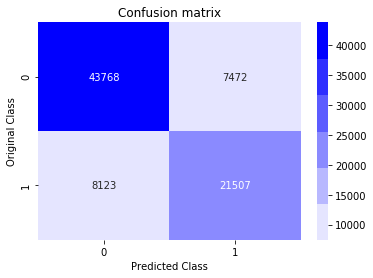

In [75]:
print("Log Loss (Training): {}\n".format(log_loss(y_train, grid_clf.best_estimator_.predict_proba(X_train))))
print("Log Loss (Testing): {}\n".format(log_loss(y_test, y_pred_prob, labels=grid_clf.best_estimator_.classes_)))
print("Accuracy Score: {}\n".format(accuracy_score(y_test, y_pred)))
print('Classification Report:\n')
print(classification_report(y_test, y_pred))
print('\nConfustion Matrix: \n')
plot_confusion_matrix(y_test, y_pred)